# Understanding figure 1c
This is a notebook that attempts to break down figure 1c in the original article https://www.nature.com/articles/s41586-020-2907-3.

In [9]:
import pickle
import rnaseqTools
import matplotlib.pyplot as plt
import pandas as pd

## 1. First, what was the original article by Scala et al. doing?

Note: This is a summary written by a person from outside neuroscience. Some of the contents may be wrong.

According to the article by Scala et al., there are two ways to classify neuron types: transcriptomic and  morpho-electric. The transcriptomic method uses the RNA sequence of neurons to determine their families. The morpho-electric (morphology and electrphysiology) method first observes actual neuron shapes by coloring them with a substance called byoctin. Next it runs electrical currents through the neurons and records the reactions of the neurons. Finally, it combines the neuron shapes to their reactions under electricity to classify the cells into families.

Scala's article combined both transcriptomic and  morpho-electric descriptions to mouse neurons from the primary motor cortex (MOp) to see what it could find. The experiment showed that the morpho-electric classification agreed with the transcriptomic classification for broad cell families (Pvalb, Vip, L5 ET, and other code-like names found in the article). However, morpho-electric classification did not match transcriptomic classification for smaller neuron subclasses. The article concludes that the neuron families may not be able to be finely labeled as the transcriptomic classification suggests, but can only be labeled by the broad families with slight within-group variations. 

When assigning transcriptomic cell types, Scala et al. referenced two transcriptomic cell data sets, one from Tasic et al. 2018 and one from Yao et al. 2020. Scala et al. first used Tasic et al.'s data set to assign initial categories to the cell samples they had. Then they did the final assignment with Yao et al.'s 7 datasets for RNA sequences.

### The referenced datasets

Yao et al. classify neurons in the primary motor cortex using RNA and DNA sequencing and chromatin. Scala et al. only use the 7 datasets for the RNA sequence for assigning transciptomic cell types.<br>
https://www.biorxiv.org/content/10.1101/2020.02.29.970558v2.full.pdf

Tasic et al. classified 23,822 neurons from mice by single-cell RNA sequencing. These neurons were from two areas of mouse brains: the primary visual cortex and the anterior lateral motor cortex.<br>
https://www.nature.com/articles/s41586-020-2907-3#Abs1

## 2. What does figure 1c indicate?

According to the article, 1c is: 
>t-SNE representation of CGE-derived interneurons from the single-cell 10x v2 reference data set (n = 15,511; perplexity, 30).
 
From what can be gathered, the main data is from the "single-cell 10x v2 reference data set". The dataset contained a set of interneurons that came from a place called CGE, and in the figure, the data is represented by something called a t-SNE.

To someone with no background in neuroscience, the questions are:
1. What is an interneuron?
2. Where and what is the CGE?
3. What is a t-SNE representation?
4. Is there any meaning to the dataset's name, and where did it come from?

__1. What is a interneuron?__

It is a common type of neuron that can be found in the brain and spinal cord. They pass signals through the nervous system, which allows us to sense and move.

__2. Where and what is the CGE?__

It is a tiny region of a brain section called the telencephalon, which is associated with the motor functions (movements) of the body. Along with the CGE, there are sections called the LGE and MGE which are also part of the telencephalon. CGE is the second largest source of cortical interneurons (number one source is MGE).

__3. What is a t-SNE?__

It is a non-linear dimensionality reduction technique developed in 2008 that is effective for high-dimensional data (to compare, PCA is a linear dimensionality reduction technique). It works by using a Gaussian distribution to calculate the conditional probability of one point choosing another point as a close neighbor. It does this for the original data and for a lower dimension representation, and then uses KL divergence to decide what low dimension representation best fits the original data. It has a parameter "perplexity", which controls the "how close is a close neighbor" aspect. Like PCA, you end up with a set of unidentifiable features that are complex combinations of the original. 

For details, look at the following:
- https://www.datacamp.com/community/tutorials/introduction-t-sne
- https://distill.pub/2016/misread-tsne/
- https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

__4. Is there any meaning to the data set's name, and where did it come from?__

Single cell sequencing is the technology of identifying a DNA or RNA sequence of one cell, and 10x sequencing is an advanced method that lets you do it. This dataset in particular is from Yao et al.'s article in 2020.

## 3. So what is figure 1c?

It is a t-SNE mapping of one group of neurons, the CGE interneurons, in one of Yao at al.'s datasets that represents the results of single cell 10x v2 RNA sequencing. This dataset can be found in `10X_cells_v2_AIBS.pickle`, a pickle file you can obtain by running `allen-data-preprocess-mod.ipynb`.

In figure 1c, clusters created by the t-SNE algorithm are colored by the actual transcriptomic cell types. Broad cell families like Vip, Lamp5, and Sncg are also plotted. The remaining groups in the dataset, the MGE interneurons and excitatory cells are mapped in figure 1d and 1e as similar plots respectively. 

### The contents of 10X_cells_v2_AIBS.pickle
It is a dictionary. The first layer keys are the subgroups: CGE interneurons (viplamp), MGE interneurons (pvsst), excitatory neurons (exc), and all groups put together (neurons). The keys each have another dictionary associated with it, which has info about the subgroups:

- __counts:__ The gene count for each cell, a sparse matrix of size `number_of_cells * number_of_genes`
- __genes:__ The gene list. This only includes 1,000 most variable genes for the neuron group and 500 most variable genes for the subgroups.
- __clusters:__ The cluster assignments for each cell. The cluster types are from Yao et al.'s article and stored in a file called `cluster.annotation.csv`. 10X_cells_v2_AIBS only uses the 88 types where `class_label != "Other"`.
- __clusterColors:__ A color assigned to each cluster. Used for plotting. This one contains the same information regardless of group.
- __clusterNames:__ A name assigned  to each cluster.
- __seqDepths:__ How many genes were read per cell. Not equal to the sum of counts, perhaps because it included genes that were not in the gene list.

### The process of t-SNE
The exact method is described in the Method section in Scala et al.'s article (https://www.nature.com/articles/s41586-020-2907-3#Sec7). This section also gives a reference to another article which invented the protocol: https://www.nature.com/articles/s41467-019-13056-x.
1. Normalize the count data so that the gene counts can be compared across all cells, each with different sequence depths. The normalization method is `log2(gene_counts_of_cell / seqdepth_of_cell * median(seqdepth_of_allcells) + 1)`
2. Do PCA on the normalized counts, so that the features are reduced from `number_of_cells * number_of_genes` to `number_of_cells * 50`
3. Perform t-SNE on the feature-reduced counts using a tool from https://github.com/KlugerLab/FIt-SNE

In [2]:
# load t-SNE representations
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-viplamp.pickle', 'rb'))
print(Z) # here you can observe that the t-SNE gave 2 dimensions

[[ -5.8759442   60.37682597]
 [-10.48374102  39.79640828]
 [ 50.39342397  23.23578936]
 ...
 [-20.37011758  -2.57229007]
 [ -2.33204118 -20.26061342]
 [-40.47070384 -33.69894807]]


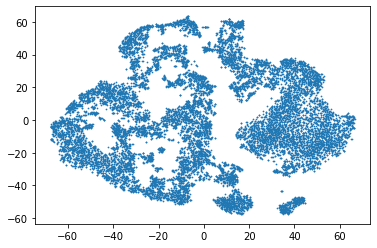

In [3]:
# and here are the clusters that were identified by t-SNE
plt.scatter(Z[:,0],Z[:,1], s=0.5)

In [132]:
clusterAnn = pd.read_csv('../data/raw/allen/yao2020/cluster.annotation.csv')

In [135]:
clusterAnn[clusterAnn["class_label"] == "Other"]

,cluster_id,cluster_label,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,cl,cluster_size,tree_order
88,89,Meis2,#C60C0F,15,Meis2,#C60C0F,3,Other,#808080,112,50,89
89,90,Meis2_Top2a,#931010,15,Meis2,#C60C0F,3,Other,#808080,116,47,90
90,94,OPC Pdgfra,#2E3E39,17,Oligo,#2E3E39,3,Other,#808080,91,5234,91
91,91,Astro_Top2a,#332F26,16,Astro,#665C47,3,Other,#808080,115,81,92
92,92,Astro Aqp4_Gfap,#5A503F,16,Astro,#665C47,3,Other,#808080,89,1739,93
93,93,Astro Aqp4_Slc7a10,#8D7C5D,16,Astro,#665C47,3,Other,#808080,90,17606,94
94,95,Oligo Enpp6_1,#374A45,17,Oligo,#2E3E39,3,Other,#808080,92,159,95
95,96,Oligo Enpp6_2,#5E8A79,17,Oligo,#2E3E39,3,Other,#808080,93,355,96
96,97,Oligo Enpp6_3,#3F574E,17,Oligo,#2E3E39,3,Other,#808080,94,105,97
97,98,Oligo Enpp6_4,#65978A,17,Oligo,#2E3E39,3,Other,#808080,95,175,98


In [148]:
m1data["viplamp"]['seqDepths'].max()

46429

In [147]:
np.sum(m1data["neurons"]['counts'][0])

2614

In [17]:
list(clusterAnn["cluster_label"])

['Lamp5 Pax6',
 'Lamp5 Egln3_1',
 'Lamp5 Egln3_2',
 'Lamp5 Egln3_3',
 'Lamp5 Pdlim5_1',
 'Lamp5 Pdlim5_2',
 'Lamp5 Slc35d3',
 'Lamp5 Lhx6',
 'Sncg Col14a1',
 'Sncg Slc17a8',
 'Sncg Calb1_1',
 'Sncg Calb1_2',
 'Sncg Npy2r',
 'Vip Sncg',
 'Vip Serpinf1_1',
 'Vip Serpinf1_2',
 'Vip Serpinf1_3',
 'Vip Htr1f',
 'Vip Gpc3',
 'Vip C1ql1',
 'Vip Mybpc1_2',
 'Vip Mybpc1_1',
 'Vip Chat_1',
 'Vip Mybpc1_3',
 'Vip Chat_2',
 'Vip Igfbp6_1',
 'Vip Igfbp6_2',
 'Sst Chodl',
 'Sst Penk',
 'Sst Myh8_1',
 'Sst Myh8_2',
 'Sst Myh8_3',
 'Sst Htr1a',
 'Sst Etv1',
 'Sst Pvalb Etv1',
 'Sst Crhr2_1',
 'Sst Crhr2_2',
 'Sst Hpse',
 'Sst Calb2',
 'Sst Pappa',
 'Sst Pvalb Calb2',
 'Sst C1ql3_1',
 'Sst C1ql3_2',
 'Sst Tac2',
 'Sst Th_1',
 'Sst Th_2',
 'Sst Th_3',
 'Pvalb Gabrg1',
 'Pvalb Egfem1',
 'Pvalb Gpr149',
 'Pvalb Kank4',
 'Pvalb Calb1_1',
 'Pvalb Calb1_2',
 'Pvalb Reln',
 'Pvalb Il1rapl2',
 'Pvalb Vipr2_1',
 'Pvalb Vipr2_2',
 'L2/3 IT_1',
 'L2/3 IT_2',
 'L2/3 IT_3',
 'L4/5 IT_1',
 'L4/5 IT_2',
 'L5 IT_1',
 

In [21]:
# a lot of the ttypes dictionary seem to be related to the data from a previous study
# It is stored in a pickle file tasic2018
tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))

In [22]:
tasic2018

{'counts': <23822x3000 sparse matrix of type '<class 'numpy.float64'>'
 	with 17616622 stored elements in Compressed Sparse Column format>,
 'genes': array(['0610040J01Rik', '1110008P14Rik', '1190002N15Rik', ..., 'Zmat4',
        'Zp2', 'Zwint'], dtype='<U28'),
 'areas': array([0, 0, 0, ..., 1, 1, 1]),
 'clusters': array([93, 72,  1, ..., 88, 34, 56]),
 'clusterColors': array(['#DDACC9', '#FF88AD', '#FFB8CE', '#DD6091', '#FF7290', '#FFA388',
        '#C77963', '#9440F3', '#9900B3', '#C266D1', '#6C00BF', '#A700FF',
        '#CA66FF', '#7779BF', '#8194CC', '#533691', '#9189FF', '#B09FFF',
        '#756FB3', '#9FAAFF', '#FF00FF', '#AF00E6', '#FF00B3', '#B3128A',
        '#FF4DC1', '#BD3D9A', '#882E81', '#AD589A', '#AC3491', '#FFFF00',
        '#FFBB33', '#804811', '#B06411', '#BF480D', '#CC6D3D', '#FFDF11',
        '#D6C300', '#FF8011', '#FF9F2C', '#FFB307', '#D9C566', '#BF9F00',
        '#806B19', '#B95541', '#C77767', '#C11331', '#BF8219', '#994C00',
        '#802600', '#A81111', '#ED4C

In [18]:
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))

In [76]:
m1data["viplamp"].keys()

dict_keys(['counts', 'genes', 'clusters', 'clusterColors', 'clusterNames', 'seqDepths'])

In [115]:
check_list = []
for gene in m1data["neurons"]["genes"]:
    check_list.append([gene in m1data["viplamp"]["genes"], gene in m1data["pvsst"]["genes"],gene in m1data["exc"]["genes"]])

check_list = np.array(check_list)
check_sum = np.sum(check_list, axis=1)

np.sum(check_sum ==0)

248

In [29]:
import tables
f = tables.open_file('../data/raw/allen/yao2020/' + '10X_cells_v2_AIBS' + '/umi_counts.h5', 'r')

In [30]:
f

File(filename=../data/raw/allen/yao2020/10X_cells_v2_AIBS/umi_counts.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/matrix (Group) ''
/matrix/barcodes (Array(145748,)) ''
  atom := StringAtom(itemsize=19, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/matrix/data (EArray(646079923,), shuffle, zlib(4)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (80000,)
/matrix/indices (EArray(646079923,), shuffle, zlib(4)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (80000,)
/matrix/indptr (EArray(145749,), shuffle, zlib(4)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (80000,)
/matrix/shape (EArray(2,), shuffle, zl